In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from typing import List, Dict, Optional
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

# Load Model Weights (may take a few minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = stable.tokenizer

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

# Pipeline Wrapper

In [4]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [5]:
def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               is_attend_and_excite: bool = True):
    token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None else indices_to_alter
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=run_standard_sd)
        images.append(image.resize((256, 256)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'frog']


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

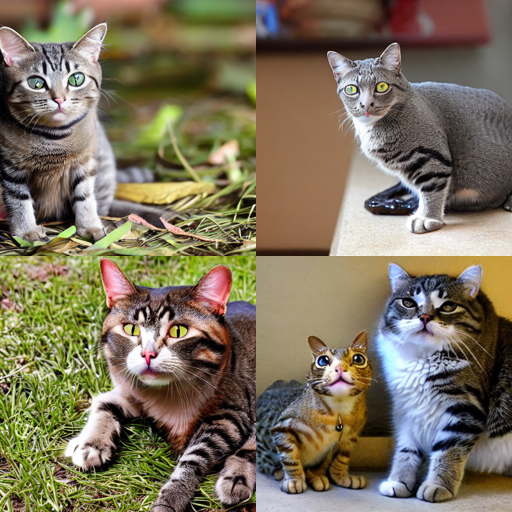

In [6]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'frog']


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0268
Iteration 1 | Loss: 0.0302
Iteration 2 | Loss: 0.0307
Iteration 3 | Loss: 0.0104
Iteration 4 | Loss: 0.0119
Iteration 5 | Loss: 0.0098
Iteration 6 | Loss: 0.0133
Iteration 7 | Loss: 0.0070
Iteration 8 | Loss: 0.0235
Iteration 9 | Loss: 0.0060
Iteration 10 | Loss: 0.0325
Iteration 11 | Loss: 0.0059
Iteration 12 | Loss: 0.0185
Iteration 13 | Loss: 0.0065
Iteration 14 | Loss: 0.0215
Iteration 15 | Loss: 0.0085
Iteration 16 | Loss: 0.0308
Iteration 17 | Loss: 0.0105
Iteration 18 | Loss: 0.0294
Iteration 19 | Loss: 0.0157
Iteration 20 | Loss: 0.0252
Iteration 21 | Loss: 0.0179
Iteration 22 | Loss: 0.0271
Iteration 23 | Loss: 0.0186
Iteration 24 | Loss: 0.0301


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0640
Iteration 1 | Loss: 0.0124
Iteration 2 | Loss: 0.0122
Iteration 3 | Loss: 0.0085
Iteration 4 | Loss: 0.0045
Iteration 5 | Loss: 0.0031
Iteration 6 | Loss: 0.0027
Iteration 7 | Loss: 0.0031
Iteration 8 | Loss: 0.0029
Iteration 9 | Loss: 0.0033
Iteration 10 | Loss: 0.0029
Iteration 11 | Loss: 0.0029
Iteration 12 | Loss: 0.0030
Iteration 13 | Loss: 0.0029
Iteration 14 | Loss: 0.0038
Iteration 15 | Loss: 0.0041
Iteration 16 | Loss: 0.0054
Iteration 17 | Loss: 0.0055
Iteration 18 | Loss: 0.0073
Iteration 19 | Loss: 0.0100
Iteration 20 | Loss: 0.0091
Iteration 21 | Loss: 0.0161
Iteration 22 | Loss: 0.0121
Iteration 23 | Loss: 0.0154
Iteration 24 | Loss: 0.0154


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1636
Iteration 1 | Loss: 0.1084
Iteration 2 | Loss: 0.1281
Iteration 3 | Loss: 0.0081
Iteration 4 | Loss: 0.0069
Iteration 5 | Loss: 0.0051
Iteration 6 | Loss: 0.0062
Iteration 7 | Loss: 0.0041
Iteration 8 | Loss: 0.0070
Iteration 9 | Loss: 0.0081
Iteration 10 | Loss: 0.0081
Iteration 11 | Loss: 0.0113
Iteration 12 | Loss: 0.0129
Iteration 13 | Loss: 0.0117
Iteration 14 | Loss: 0.0120
Iteration 15 | Loss: 0.0103
Iteration 16 | Loss: 0.0106
Iteration 17 | Loss: 0.0114
Iteration 18 | Loss: 0.0113
Iteration 19 | Loss: 0.0143
Iteration 20 | Loss: 0.0141
Iteration 21 | Loss: 0.0177
Iteration 22 | Loss: 0.0179
Iteration 23 | Loss: 0.0208
Iteration 24 | Loss: 0.0220


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0832
Iteration 1 | Loss: 0.0092
Iteration 2 | Loss: 0.0090
Iteration 3 | Loss: 0.0062
Iteration 4 | Loss: 0.0051
Iteration 5 | Loss: 0.0058
Iteration 6 | Loss: 0.0047
Iteration 7 | Loss: 0.0243
Iteration 8 | Loss: 0.0056
Iteration 9 | Loss: 0.0077
Iteration 10 | Loss: 0.0077
Iteration 11 | Loss: 0.0090
Iteration 12 | Loss: 0.0095
Iteration 13 | Loss: 0.0106
Iteration 14 | Loss: 0.0105
Iteration 15 | Loss: 0.0136
Iteration 16 | Loss: 0.0123
Iteration 17 | Loss: 0.0162
Iteration 18 | Loss: 0.0157
Iteration 19 | Loss: 0.0149
Iteration 20 | Loss: 0.0201
Iteration 21 | Loss: 0.0164
Iteration 22 | Loss: 0.0201
Iteration 23 | Loss: 0.0200
Iteration 24 | Loss: 0.0218


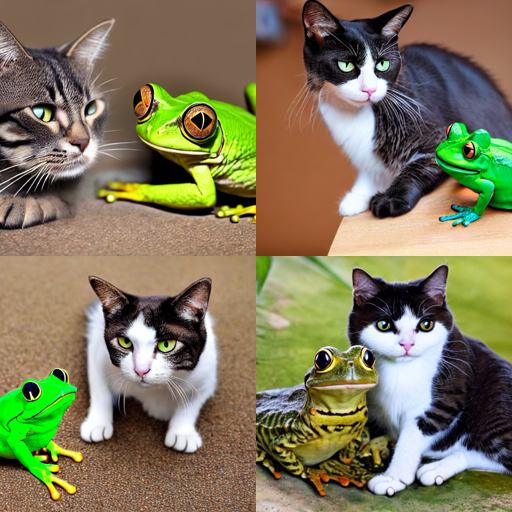

In [7]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=True
)

## Stable Diffusion

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,6
Altering tokens: ['mouse', 'car']


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

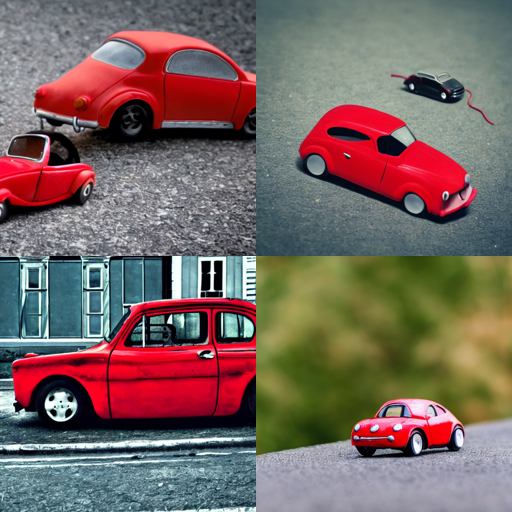

In [8]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,6
Altering tokens: ['mouse', 'car']


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8951
Iteration 1 | Loss: 0.0164
Iteration 2 | Loss: 0.0147
Iteration 3 | Loss: 0.0004
Iteration 4 | Loss: 0.0002
Iteration 5 | Loss: 0.0001
Iteration 6 | Loss: 0.0003
Iteration 7 | Loss: 0.0004
Iteration 8 | Loss: 0.0011
Iteration 9 | Loss: 0.0032
Iteration 10 | Loss: 0.0042
Iteration 11 | Loss: 0.0156
Iteration 12 | Loss: 0.0144
Iteration 13 | Loss: 0.0366
Iteration 14 | Loss: 0.0349
Iteration 15 | Loss: 0.0452
Iteration 16 | Loss: 0.0412
Iteration 17 | Loss: 0.0397
Iteration 18 | Loss: 0.0353
Iteration 19 | Loss: 0.0356
Iteration 20 | Loss: 0.0384
Iteration 21 | Loss: 0.0429
Iteration 22 | Loss: 0.0425
Iteration 23 | Loss: 0.0449
Iteration 24 | Loss: 0.0462


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8404
Iteration 1 | Loss: 0.0049
Iteration 2 | Loss: 0.0042
Iteration 3 | Loss: 0.0037
Iteration 4 | Loss: 0.0032
Iteration 5 | Loss: 0.0018
Iteration 6 | Loss: 0.0036
Iteration 7 | Loss: 0.0046
Iteration 8 | Loss: 0.0069
Iteration 9 | Loss: 0.0098
Iteration 10 | Loss: 0.0102
Iteration 11 | Loss: 0.0140
Iteration 12 | Loss: 0.0130
Iteration 13 | Loss: 0.0151
Iteration 14 | Loss: 0.0146
Iteration 15 | Loss: 0.0165
Iteration 16 | Loss: 0.0176
Iteration 17 | Loss: 0.0204
Iteration 18 | Loss: 0.0221
Iteration 19 | Loss: 0.0241
Iteration 20 | Loss: 0.0265
Iteration 21 | Loss: 0.0280
Iteration 22 | Loss: 0.0316
Iteration 23 | Loss: 0.0334
Iteration 24 | Loss: 0.0375


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8941
Iteration 1 | Loss: 0.6063
Iteration 2 | Loss: 0.5246
Iteration 3 | Loss: 0.1056
Iteration 4 | Loss: 0.0053
Iteration 5 | Loss: 0.0216
Iteration 6 | Loss: 0.0154
Iteration 7 | Loss: 0.0197
Iteration 8 | Loss: 0.0252
Iteration 9 | Loss: 0.0283
Iteration 10 | Loss: 0.0445
Iteration 11 | Loss: 0.0351
Iteration 12 | Loss: 0.0587
Iteration 13 | Loss: 0.0395
Iteration 14 | Loss: 0.0610
Iteration 15 | Loss: 0.0396
Iteration 16 | Loss: 0.0483
Iteration 17 | Loss: 0.0419
Iteration 18 | Loss: 0.0429
Iteration 19 | Loss: 0.0393
Iteration 20 | Loss: 0.0406
Iteration 21 | Loss: 0.0382
Iteration 22 | Loss: 0.0406
Iteration 23 | Loss: 0.0373
Iteration 24 | Loss: 0.0420


  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.7277
Iteration 1 | Loss: 0.0227
Iteration 2 | Loss: 0.0199
Iteration 3 | Loss: 0.0058
Iteration 4 | Loss: 0.0110
Iteration 5 | Loss: 0.0154
Iteration 6 | Loss: 0.0231
Iteration 7 | Loss: 0.0210
Iteration 8 | Loss: 0.0348
Iteration 9 | Loss: 0.0232
Iteration 10 | Loss: 0.0410
Iteration 11 | Loss: 0.0319
Iteration 12 | Loss: 0.0405
Iteration 13 | Loss: 0.0651
Iteration 14 | Loss: 0.0572
Iteration 15 | Loss: 0.0783
Iteration 16 | Loss: 0.0598
Iteration 17 | Loss: 0.0642
Iteration 18 | Loss: 0.0450
Iteration 19 | Loss: 0.0556
Iteration 20 | Loss: 0.0369
Iteration 21 | Loss: 0.0497
Iteration 22 | Loss: 0.0317
Iteration 23 | Loss: 0.0451
Iteration 24 | Loss: 0.0308


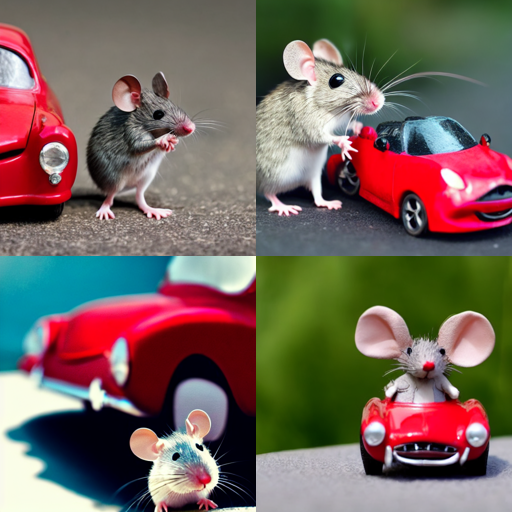

In [9]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=True
)